### Imports

In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from collections import defaultdict
from sqlalchemy import select, func
from sqlalchemy.orm import Session

from data.models import ResearchPaper, PerplexityScoreEvent
from data.db import get_db_session
from services.arxiv import arxiv_taxonomy

### Environment Setup

In [2]:
current_directory = os.getcwd()
images_directory = os.path.join(current_directory, "images")
if not os.path.exists(images_directory):
    os.makedirs(images_directory)

sns.set_theme(style="darkgrid", palette="muted", font_scale=1.2)


SOURCE_MAP = {
    "original": "real abstract",
    "human": "fake abstract",
    "gpt4": "fake abstract"
}

session = get_db_session()

Connecting to database: capstone-database.cypu4cisag61.us-east-1.rds.amazonaws.com:5432/postgres


### Util Functions

In [14]:

def get_research_papers(session: Session):
    stmt = select(ResearchPaper.category, ResearchPaper.doi)
    return session.execute(stmt).fetchall()

def classify_papers(paper: ResearchPaper) -> str:
    """
    Determine the domain of a paper based on its category or other attributes.
    
    Args:
        paper: The ResearchPaper object
        
    Returns:
        str: The determined domain (e.g., "Neuroscience", "Economics", "Optometry")
    """
    # Convert category to lowercase for case-insensitive matching
    category_lower = paper.category.lower() if paper.category else ""
    
    # Check for optometry category first
    if "optometry" in category_lower:
        return "optometry"
    
    # Get economics categories from arxiv taxonomy
    economics_categories = list(arxiv_taxonomy.get("Economics", {}).keys())
    
    # Create extended list that includes related economics categories
    extended_econ_categories = economics_categories + [
        "q-fin.EC",       # Economics in Quantitative Finance
        "q-fin.GN",       # General Finance
        "q-fin.PM",       # Portfolio Management
        "q-fin.RM",       # Risk Management
        "q-fin.ST",       # Statistical Finance
        "q-fin.TR",       # Trading and Microstructure
        "economics",      # Generic category
        "finance",        # Generic category
        "econometrics"    # Generic category
    ]
    
    # Check if paper falls within economics categories
    for econ_cat in extended_econ_categories:
        if econ_cat.lower() in category_lower:
            return "economics"
    
    # Default to neuroscience domain for all other categories
    return "neuroscience"

def count_domains(session: Session) -> dict:
    """
    Classify and count papers by domain in the research_papers table.
    
    Args:
        db: SQLAlchemy Session object connected to the database.
    
    Returns:
        dict: A count of papers in each domain (neuroscience, economics, optometry).
    """
    papers = session.query(ResearchPaper).all()
    domain_counts = Counter()

    for paper in papers:
        domain = classify_papers(paper)
        domain_counts[domain] += 1

    return dict(domain_counts)

def plot_distribution(counts):
    categories = list(counts.keys())
    values = list(counts.values())

    plt.figure(figsize=(8, 6))
    ax = sns.barplot(x=categories, y=values, hue=categories, palette="muted", edgecolor="white")

    ax.set_title("Research Paper Distribution by Domain", fontsize=16)
    ax.set_ylabel("Number of Papers", fontsize=14)
    ax.set_xlabel("Domains", fontsize=14)

    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', fontsize=12, color='black', 
                    xytext=(0, 10), textcoords='offset points')

    plt.tight_layout()
    plt.savefig(os.path.join(images_directory, "paper_category_distribution.png"), dpi=300)
    plt.show()
    plt.close()

def fetch_perplexity_data(session: Session) -> pd.DataFrame:
    stmt = select(
        PerplexityScoreEvent.research_paper_id,
        PerplexityScoreEvent.perplexity_score,
        PerplexityScoreEvent.zlib_perplexity_ratio,
        PerplexityScoreEvent.abstract_source
    )
    results = session.execute(stmt).all()
    df = pd.DataFrame(results, columns=[
        "research_paper_id", "perplexity_score", "zlib_perplexity_ratio", "abstract_source"
    ])
    df["abstract_source"] = df["abstract_source"].map(SOURCE_MAP).dropna()
    return df

def group_metric_by_source(df: pd.DataFrame, metric: str) -> dict:
    grouped = {}
    for label in df["abstract_source"].unique():
        grouped[label] = df.loc[df["abstract_source"] == label, metric].dropna().tolist()
    return grouped

def plot_histogram(grouped_data: dict, metric: str, bins=30, range=None, title=None, filename=None):
    df = pd.DataFrame([
        {metric: value, "source": key}
        for key, values in grouped_data.items()
        for value in values
    ])

    plt.figure(figsize=(8, 6))
    ax = sns.histplot(
        data=df,
        x=metric,
        hue="source",  
        bins=bins,
        kde=True,
        element='bars',
        edgecolor="white",
        palette="muted"
    )
    ax.set_title(title or f"{metric} by Abstract Source", fontsize=14)
    ax.set_xlabel(metric.replace("_", " ").title(), fontsize=12)
    ax.set_ylabel("Frequency", fontsize=12)

    if metric == "zlib_perplexity_ratio":
        plt.xlim(0, 0.05)
    elif metric == "perplexity_score":
        plt.xlim(0, 20)

    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.tight_layout()
    if filename:
        plt.savefig(os.path.join(images_directory, filename), dpi=300)
    plt.show()
    plt.close()


def plot_accuracy_by_model(session: Session):
    subquery = (
        session.query(
            PerplexityScoreEvent.research_paper_id,
            PerplexityScoreEvent.model,
            func.min(PerplexityScoreEvent.perplexity_score).label("min_score")
        )
        .group_by(PerplexityScoreEvent.research_paper_id, PerplexityScoreEvent.model)
        .subquery()
    )

    rows = (
        session.query(PerplexityScoreEvent)
        .join(subquery,
              (PerplexityScoreEvent.research_paper_id == subquery.c.research_paper_id) &
              (PerplexityScoreEvent.model == subquery.c.model) &
              (PerplexityScoreEvent.perplexity_score == subquery.c.min_score))
        .all()
    )

    result = defaultdict(lambda: {"correct": 0, "wrong": 0})

    for row in rows:
        if row.abstract_source == "original":
            result[row.model]["correct"] += 1
        else:
            result[row.model]["wrong"] += 1

    model_name_map = {
        "deepseek-ai/DeepSeek-R1": "Deepseek R1",
        "meta-llama/Llama-3.3-70B-Instruct-Turbo": "Llama 3.3-70B",
        "mistralai/Mixtral-8x7B-v0.1": "Mistral 8x7B",
        "deepseek-ai/DeepSeek-V3": "Deepseek V3"
    }

    original_models = ["deepseek-ai/DeepSeek-R1", "meta-llama/Llama-3.3-70B-Instruct-Turbo", "mistralai/Mixtral-8x7B-v0.1", "deepseek-ai/DeepSeek-V3"]
    models = ["Deepseek R1", "Llama 3.3-70B", "Mistral 8x7B", "Deepseek V3"]
    accuracies = []

    for model in models:
        original_model_name = next(key for key, value in model_name_map.items() if value == model)
        counts = result.get(original_model_name, {"correct": 0, "wrong": 0})
        total = counts["correct"] + counts["wrong"]
        accuracy = counts["correct"] / total if total > 0 else 0
        accuracies.append(accuracy)

    accuracy_data = pd.DataFrame({
        "Model": models,
        "Accuracy": accuracies
    })

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=accuracy_data, x='Model', y='Accuracy', hue='Model', edgecolor="white", palette="muted", legend=False)
    ax.set_ylabel("Accuracy", fontsize=14)
    ax.set_xlabel("Model", fontsize=14)
    ax.set_title("Accuracy per Model", fontsize=16)
    ax.set_ylim(0, 1)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(os.path.join(images_directory, "accuracy_by_model.png"), dpi=300)
    plt.show()
    plt.close()

def obtain_perplexity_and_research_paper_data(session: Session):
    stmt = select(
        PerplexityScoreEvent.research_paper_id,
        PerplexityScoreEvent.perplexity_score,
        PerplexityScoreEvent.zlib_perplexity_ratio,
        PerplexityScoreEvent.model,
        PerplexityScoreEvent.abstract_source,
        PerplexityScoreEvent.additional_metadata
    )

    results = session.execute(stmt).all()
    perplexity_scores= pd.DataFrame(results, columns=[
        "research_paper_id", "perplexity_score", "zlib_perplexity_ratio", "model", "abstract_source", "additional_metadata"
    ])


    stmt2 = select(
        ResearchPaper.id,
        ResearchPaper.title,
        ResearchPaper.category
    )
    results2 = session.execute(stmt2).all()
    research_papers = pd.DataFrame(results2, columns=[
        "id", "title", "category"
    ])

    df = pd.merge(perplexity_scores, research_papers, left_on='research_paper_id', right_on='id', how='left')

    return df

model_name_map = {
        "deepseek-ai/DeepSeek-R1": "Deepseek R1",
        "meta-llama/Llama-3.3-70B-Instruct-Turbo": "Llama 3.3-70B",
        "mistralai/Mixtral-8x7B-v0.1": "Mistral 8x7B",
        "deepseek-ai/DeepSeek-V3": "Deepseek V3"
    }

def plot_confidence_histogram(df, RAG = False):
    if RAG:
        df = df[df.additional_metadata != None]
    else:
        df = df[df.additional_metadata.isna()]

    df['model'] = df['model'].map(model_name_map)

    agg_df = df.groupby(['research_paper_id', 'model']).agg(
        min_perplexity=('perplexity_score', 'min'),
        max_perplexity=('perplexity_score', 'max')
    ).reset_index()
    agg_df['confidence'] = agg_df['max_perplexity'] - agg_df['min_perplexity']
    sorted_df = df.sort_values(by='perplexity_score')

    lowest_df = sorted_df.groupby(['research_paper_id', 'model'], as_index=False).first()
    lowest_df['correct'] = lowest_df['abstract_source'] == 'original'
    merged_df = pd.merge(lowest_df, agg_df, on = ['research_paper_id', 'model'])

    g = sns.displot(data=merged_df, x='confidence', col='model', col_wrap=2, height=5, aspect=1)
    for ax, model_name in zip(g.axes.flat, merged_df['model'].unique()):
        ax.set_title(model_name, fontsize=12)

    for ax in g.axes.flat:
        ax.set_ylim(0, 200)
        ax.set_xlim(0, 0.2)
        ax.tick_params(axis='x', rotation=45) 

    title = "Model Confidence Histogram (RAG Context)" if RAG else "Model Confidence Histogram (No RAG)"
    g.fig.suptitle(title, fontsize=16)
    
    plt.tight_layout()
    if RAG:
        plt.savefig(os.path.join(images_directory, "model_confidence_histogram_RAG.png"), dpi=300)
    else:
        plt.savefig(os.path.join(images_directory, "model_confidence_histogram.png"), dpi=300)
    plt.show()
    plt.close()

def plot_model_calibration_curves(df, RAG = False):
    
    if RAG:
        df = df[df.additional_metadata != None]
        plot_title = "Model Calibration with RAG Contexts"
    else:
        df = df[df.additional_metadata.isna()]
        plot_title = "Model Calibration without RAG (Baseline)"

    df['model'] = df['model'].map(model_name_map)

    # In order to calculate confidence, you subtract the max and min perplexity score 
    # The higher the difference, the more confident the model is of its answer
    agg_df = df.groupby(['research_paper_id', 'model']).agg(
        min_perplexity=('perplexity_score', 'min'),
        max_perplexity=('perplexity_score', 'max')
    ).reset_index()
    agg_df['confidence'] = agg_df['max_perplexity'] - agg_df['min_perplexity']
    sorted_df = df.sort_values(by='perplexity_score')

    # To determine if the model's choice was correct, we have to look at the abstract_source with the lowest perplexity
    lowest_df = sorted_df.groupby(['research_paper_id', 'model'], as_index=False).first()
    lowest_df['correct'] = lowest_df['abstract_source'] == 'original'
    lowest_df[['research_paper_id', 'model', 'perplexity_score', 'zlib_perplexity_ratio', 'abstract_source', 'correct']]

    # We merged the two df's
    merged_df = pd.merge(lowest_df, agg_df, on = ['research_paper_id', 'model'])

    # This to bin the confidence level for each model 
    def bin_confidence(group, bins = 20):
        group = group.sort_values(by='confidence', ascending=True).reset_index(drop=True)
        group['confidence_bin'] = pd.qcut(group['confidence'], q=bins, labels=False, duplicates='drop')
        return group

    binned_df = merged_df.groupby('model', group_keys=False).apply(bin_confidence)

    binned_df.groupby('model')['confidence_bin'].nunique()
    # This to bin the confidence level for each model

    binned_stats_df = binned_df.groupby(['model', 'confidence_bin']).agg(
        avg_accuracy=('correct', 'mean'),
        count=('correct', 'count')
    ).reset_index()

    plt.figure(figsize=(10, 6))

    # Line plot: accuracy per confidence bin
    sns.lineplot(
        data=binned_stats_df,
        x='confidence_bin',
        y='avg_accuracy',
        hue='model',
        marker='o',
        palette='tab10'
    )

    plt.title(plot_title)
    plt.xlabel("Confidence Bin (0 = Lowest Confidence, 19 = Highest Confidence)")
    plt.ylabel("Average Accuracy")
    plt.ylim(0, 1.05)
    plt.xticks(ticks=range(0,20))
    plt.legend(title='Model')
    plt.grid(True)
    plt.tight_layout()
    if RAG:
        plt.savefig(os.path.join(images_directory, "model_calibration_curves_RAG.png"), dpi=300)
    else:
        plt.savefig(os.path.join(images_directory, "model_calibration_curves.png"), dpi=300)
    plt.show()
    plt.close()

def plot_zlib_perplexity_ratio_histogram(df, RAG = False):
    if RAG:
        df = df[df.additional_metadata != None]
        plot_title = "Zlib Perplexity Ratio Histogram (RAG Context)"
    else:
        df = df[df.additional_metadata.isna()]
        plot_title = "Zlib Perplexity Ratio Histogram (No RAG)"
    
    df['model'] = df['model'].map(model_name_map)

    g = sns.displot(data=df, x='zlib_perplexity_ratio', col='model', col_wrap=2, height=5, aspect=1)
    for ax, model_name in zip(g.axes.flat, df['model'].unique()):
        ax.set_title(model_name, fontsize=12)

    for ax in g.axes.flat:
        ax.set_ylim(0, 200)
        ax.set_xlim(0, 0.02)
        ax.tick_params(axis='x', rotation=45) 
    
    g.fig.suptitle(plot_title, fontsize=16)

    plt.tight_layout()
    if RAG:
        plt.savefig(os.path.join(images_directory, "zlib_perplexity_ratio_histogram_by_model_RAG.png"), dpi=300)
    else:
        plt.savefig(os.path.join(images_directory, "zlib_perplexity_ratio_histogram_by_model.png"), dpi=300)
    plt.show()
    plt.close()

def plot_perplexity_histogram_by_model(df, RAG = False):
    if RAG:
        df = df[df.additional_metadata != None]
        plot_title = "Perplexity Histogram (RAG Context)"
    else:
        df = df[df.additional_metadata.isna()]
        plot_title = "Perplexity Histogram (No RAG)"
    
    df['model'] = df['model'].map(model_name_map)

    g = sns.displot(data=df, x='perplexity_score', col='model', col_wrap=2, height=5, aspect=1)
    for ax, model_name in zip(g.axes.flat, df['model'].unique()):
        ax.set_title(model_name, fontsize=12)

    for ax in g.axes.flat:
        ax.set_ylim(0, 500)
        ax.set_xlim(0, 2)
        ax.tick_params(axis='x', rotation=45)

    g.fig.suptitle(plot_title, fontsize=16) 
    plt.tight_layout()
    if RAG:
        plt.savefig(os.path.join(images_directory, "perplexity_histogram_by_model_RAG.png"), dpi=300)
    else:
        plt.savefig(os.path.join(images_directory, "perplexity_histogram_by_model.png"), dpi=300)
    plt.show()
    plt.close()

def classify_paper(category):
    if not category:
        return "neuroscience"
    
    category_lower = category.lower()
    
    if "optometry" in category_lower:
        return "optometry"

    econ_keywords = [
        "economics", "econometrics", "finance",
        "q-fin.ec", "q-fin.gn", "q-fin.pm",
        "q-fin.rm", "q-fin.st", "q-fin.tr"
     ]
    
    economics_categories = list(arxiv_taxonomy.get("Economics", {}).keys())

    extended_econ_keywords = econ_keywords + economics_categories
    for econ_cat in extended_econ_keywords:
        if econ_cat.lower() in category_lower:
            return "economics"

    return "neuroscience"

def accuracy_by_subject_by_model(df, RAG = False):
    if RAG:
        df = df[df.additional_metadata != None]
        plot_title = "Accuracy by Subject and Model (RAG Context)"
    else:
        df = df[df.additional_metadata.isna()]
        plot_title = "Accuracy by Subject and Model (No RAG)"
    
    df['model'] = df['model'].map(model_name_map)
    
    # Getting accuracy per model per topic 
    df['topic']= df['category'].apply(classify_paper)
    sorted_df = df.sort_values(by='perplexity_score', ascending=True)
    lowest_perplexity_df = sorted_df.groupby(['research_paper_id', 'model'], as_index=False).first()
    lowest_perplexity_df['correct'] = lowest_perplexity_df['abstract_source'].str.lower() == 'original'
    accuracy_by_topic_model = lowest_perplexity_df.groupby(['model', 'topic'])['correct'].mean().reset_index()
    accuracy_by_topic_model.rename(columns={'correct': 'accuracy'}, inplace=True)

    #visualization
    plt.figure(figsize=(14, 8))
    sns.barplot(data=accuracy_by_topic_model, x='topic', y='accuracy', hue='model')
    plt.legend(title='Model', loc='upper right')
    plt.title(plot_title)
    plt.ylabel("Accuracy")
    plt.xlabel("")
    plt.ylim(0, 1.05)
    plt.xticks(rotation=0)
    plt.tight_layout()

    if RAG:
        plt.savefig(os.path.join(images_directory, "accuracy_by_subject_by_model_RAG.png"), dpi=300)
    else:
        plt.savefig(os.path.join(images_directory, "accuracy_by_subject_by_model.png"), dpi=300)
    plt.show()
    plt.close()


### Research Paper Domain Distribution

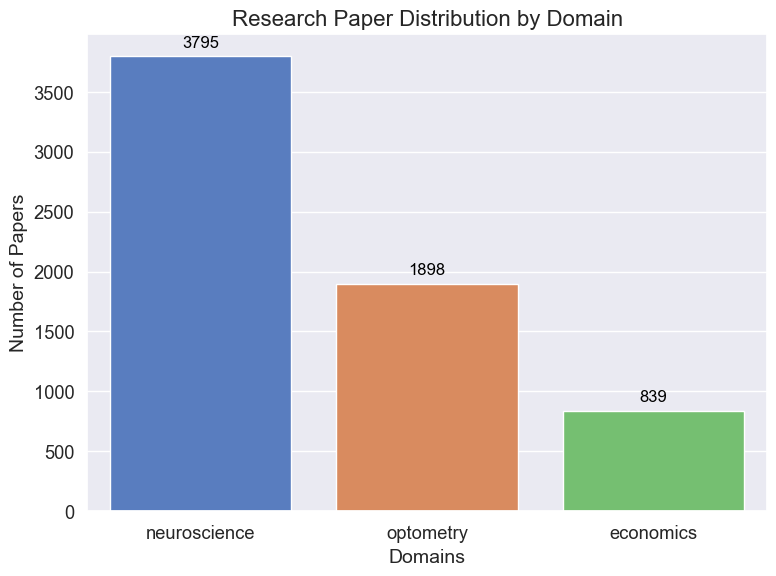

In [15]:
counts = count_domains(session)
plot_distribution(counts)

### Perplexity Score Distribution by Abstract Source

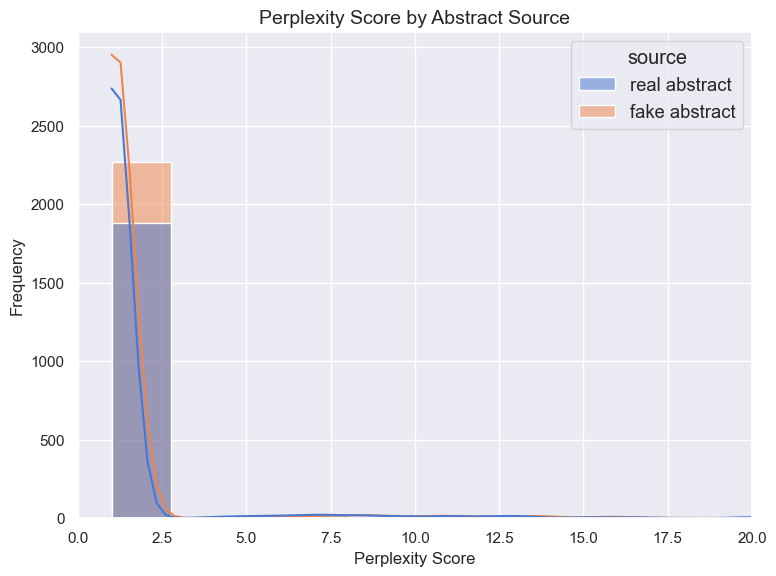

In [16]:
df = fetch_perplexity_data(session)
perplexity_grouped = group_metric_by_source(df, "perplexity_score")
plot_histogram(perplexity_grouped, "perplexity_score", title="Perplexity Score by Abstract Source", filename="perplexity_histogram.png")

### Zlib-Perplexity Ratio Distribution by Abstract Source

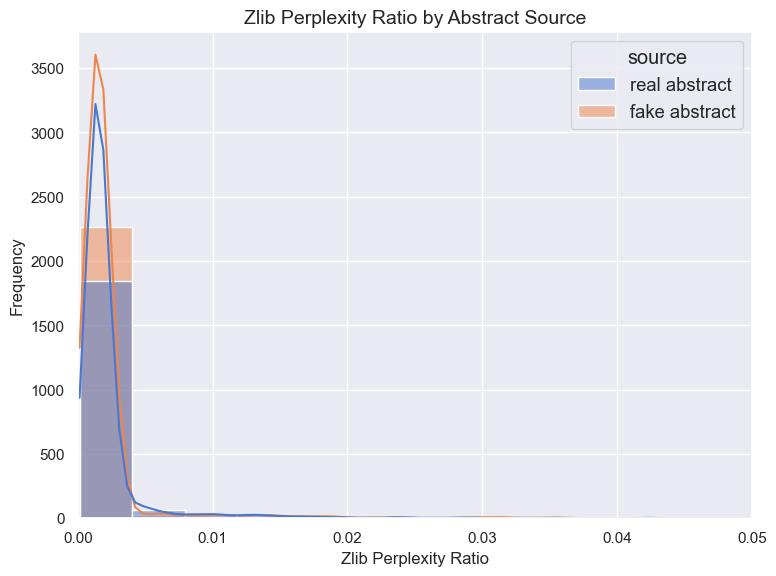

In [17]:
zlib_grouped = group_metric_by_source(df, "zlib_perplexity_ratio")
plot_histogram(zlib_grouped, "zlib_perplexity_ratio", title="Zlib Perplexity Ratio by Abstract Source", filename="zlib_perplexity_histogram.png")

### Classification Accuracy by Model

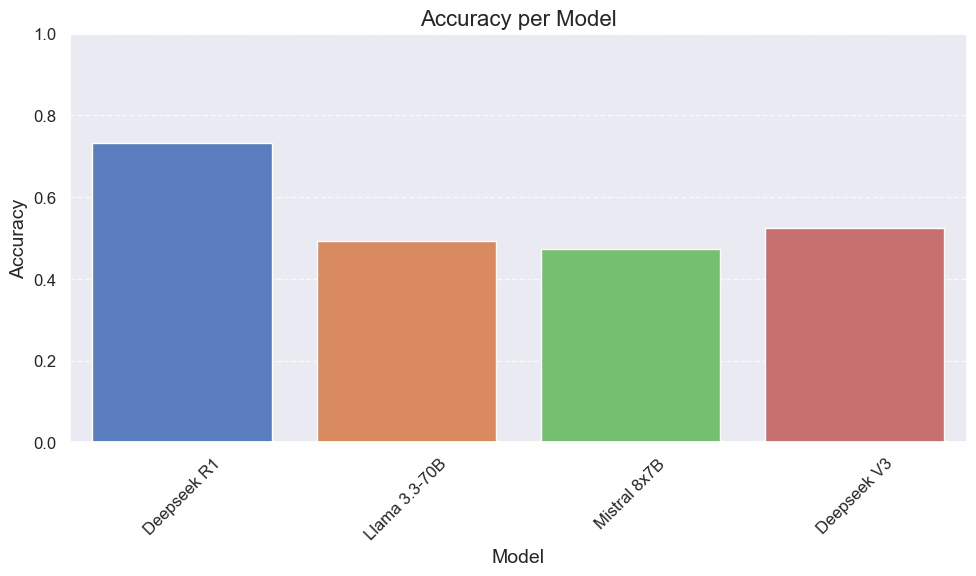

In [18]:
plot_accuracy_by_model(session)

### Model Confidence Histogram with and without RAG

/var/folders/z6/d0zj0b9s1lv9vyh5km30751h0000gn/T/ipykernel_33383/1110102520.py:218: SAWarning: TypeDecorator JSONType() will not produce a cache key because the ``cache_ok`` attribute is not set to True.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this type object's state is safe to use in a cache key, or False to disable this warning. (Background on this warning at: https://sqlalche.me/e/20/cprf)
  results = session.execute(stmt).all()


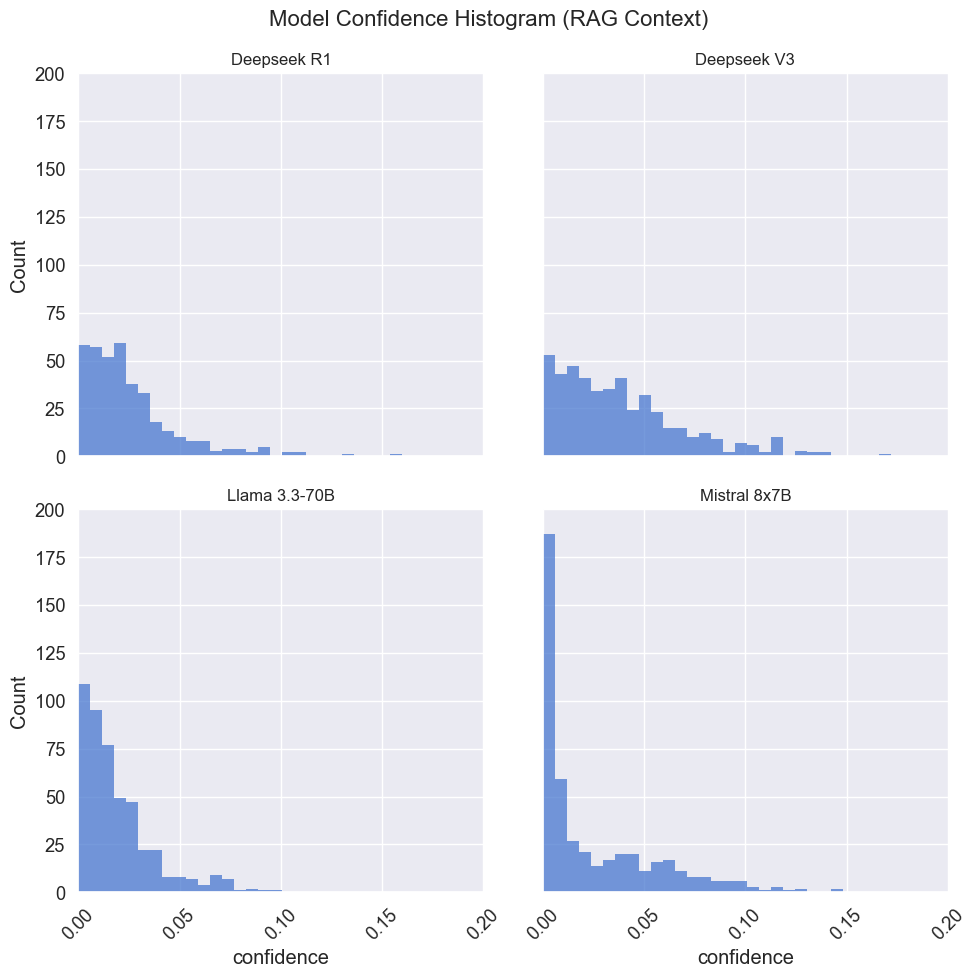

/var/folders/z6/d0zj0b9s1lv9vyh5km30751h0000gn/T/ipykernel_33383/1110102520.py:251: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['model'] = df['model'].map(model_name_map)


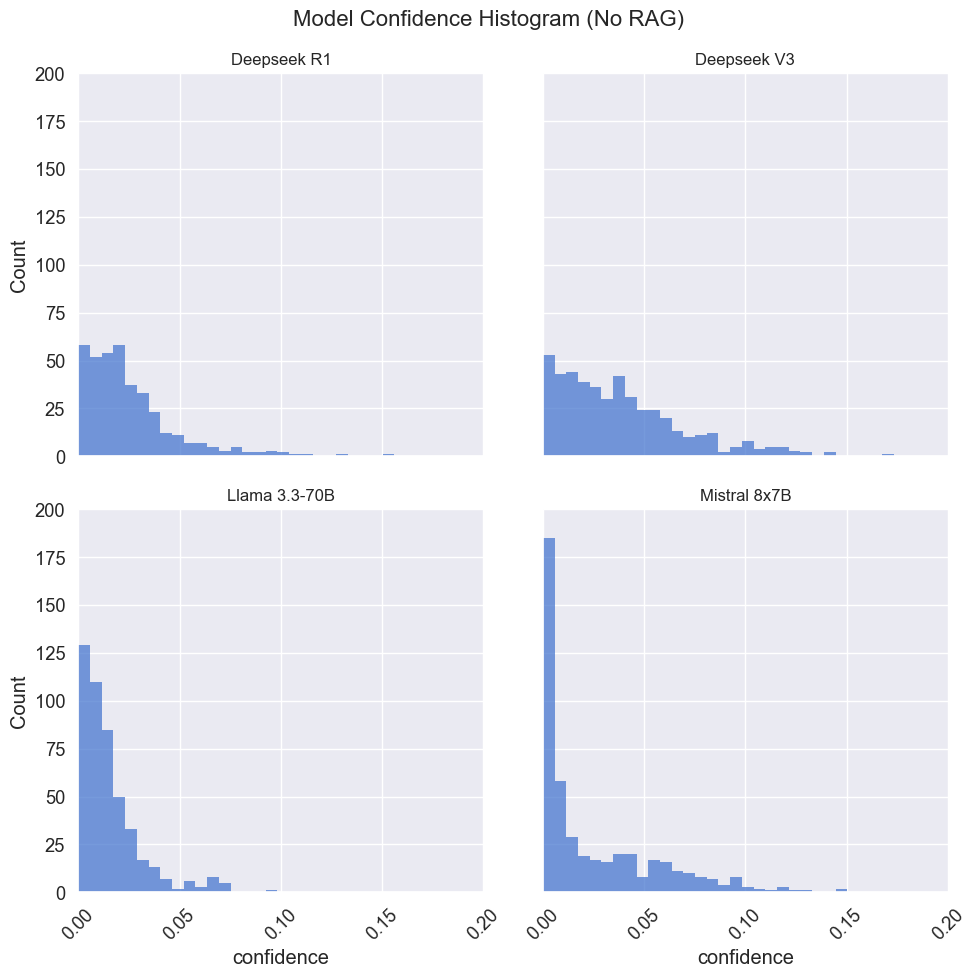

In [19]:
df2 = obtain_perplexity_and_research_paper_data(session)
plot_confidence_histogram(df2, RAG = True)
plot_confidence_histogram(df2, RAG = False)

/var/folders/z6/d0zj0b9s1lv9vyh5km30751h0000gn/T/ipykernel_33383/1110102520.py:318: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  binned_df = merged_df.groupby('model', group_keys=False).apply(bin_confidence)


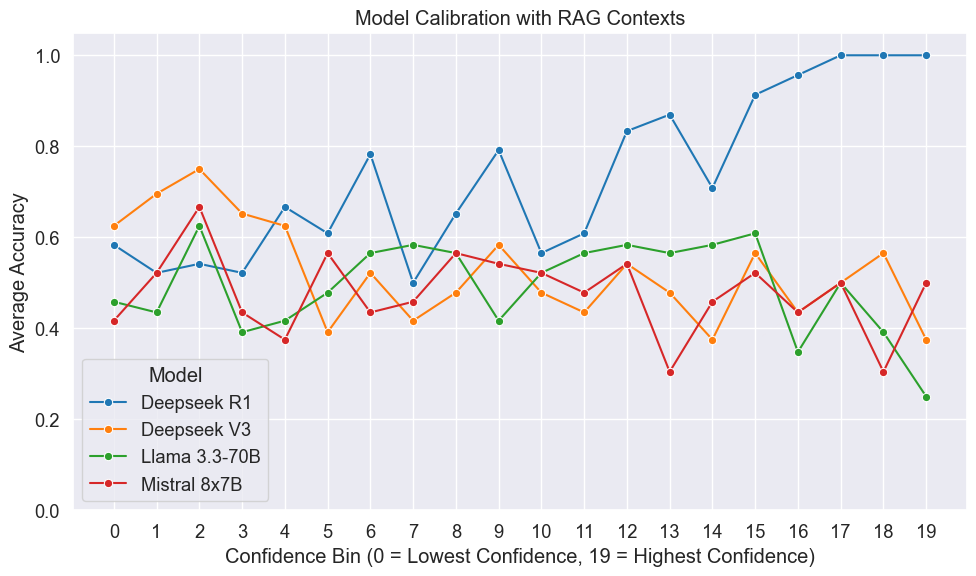

/var/folders/z6/d0zj0b9s1lv9vyh5km30751h0000gn/T/ipykernel_33383/1110102520.py:293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['model'] = df['model'].map(model_name_map)
/var/folders/z6/d0zj0b9s1lv9vyh5km30751h0000gn/T/ipykernel_33383/1110102520.py:318: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  binned_df = merged_df.groupby('model', group_keys=False).apply(bin_confidence)


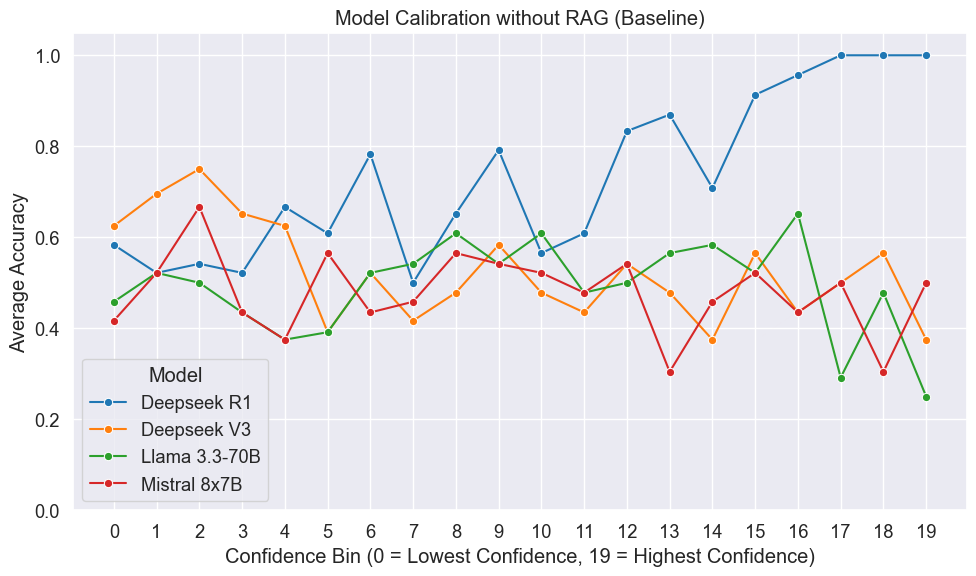

In [20]:
plot_model_calibration_curves(df2, RAG = True)
plot_model_calibration_curves(df2, RAG = False)

/var/folders/z6/d0zj0b9s1lv9vyh5km30751h0000gn/T/ipykernel_33383/1110102520.py:363: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['model'] = df['model'].map(model_name_map)


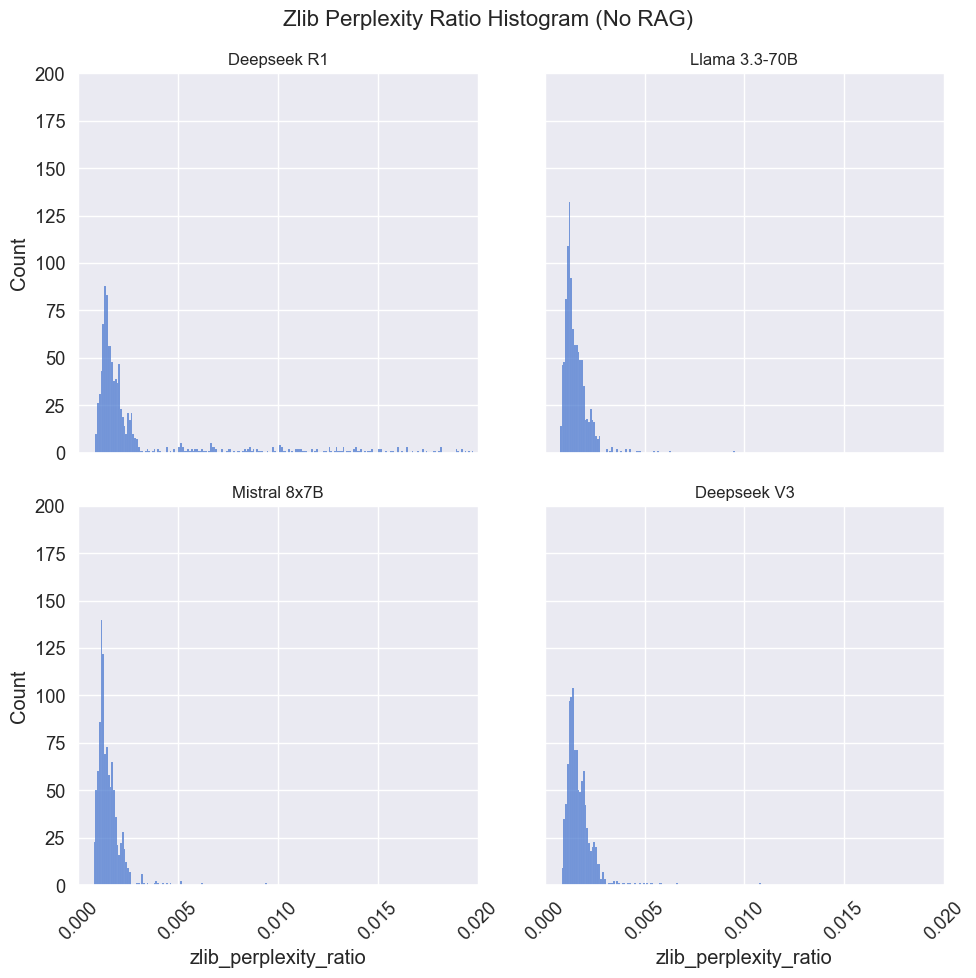

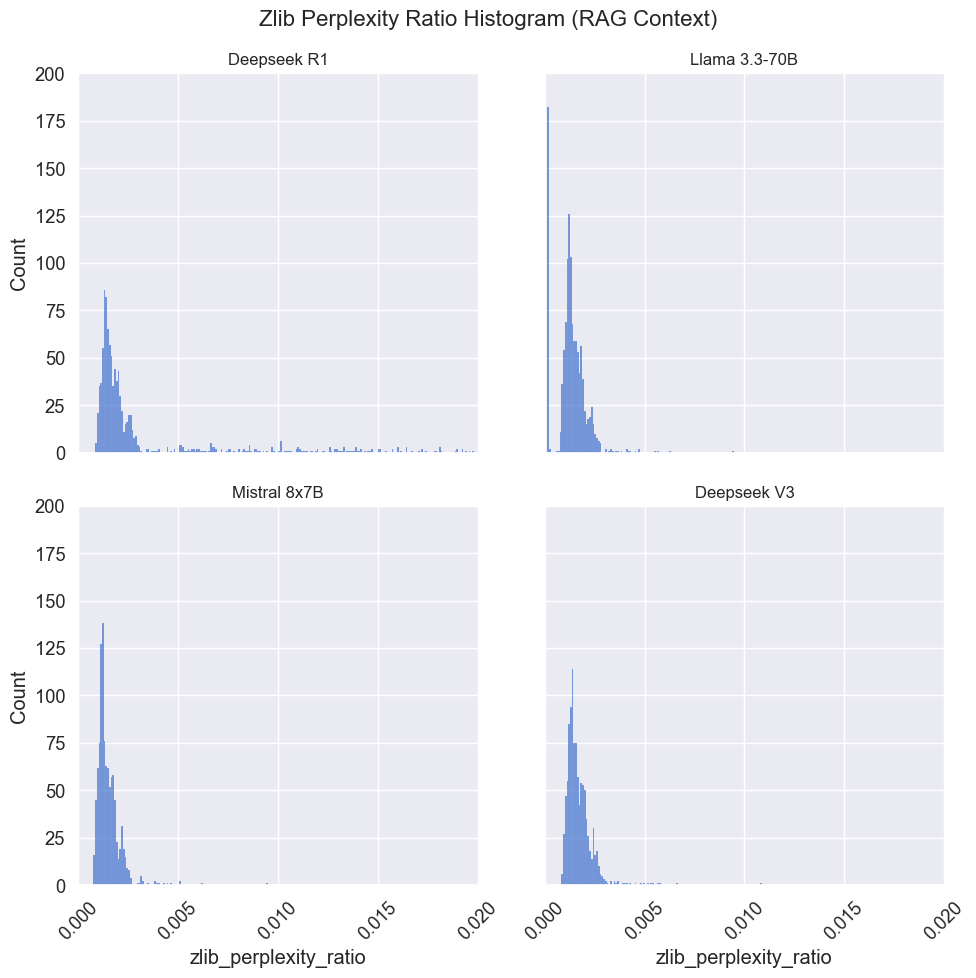

In [21]:
plot_zlib_perplexity_ratio_histogram(df2, RAG = False)
plot_zlib_perplexity_ratio_histogram(df2, RAG = True)

/var/folders/z6/d0zj0b9s1lv9vyh5km30751h0000gn/T/ipykernel_33383/1110102520.py:392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['model'] = df['model'].map(model_name_map)


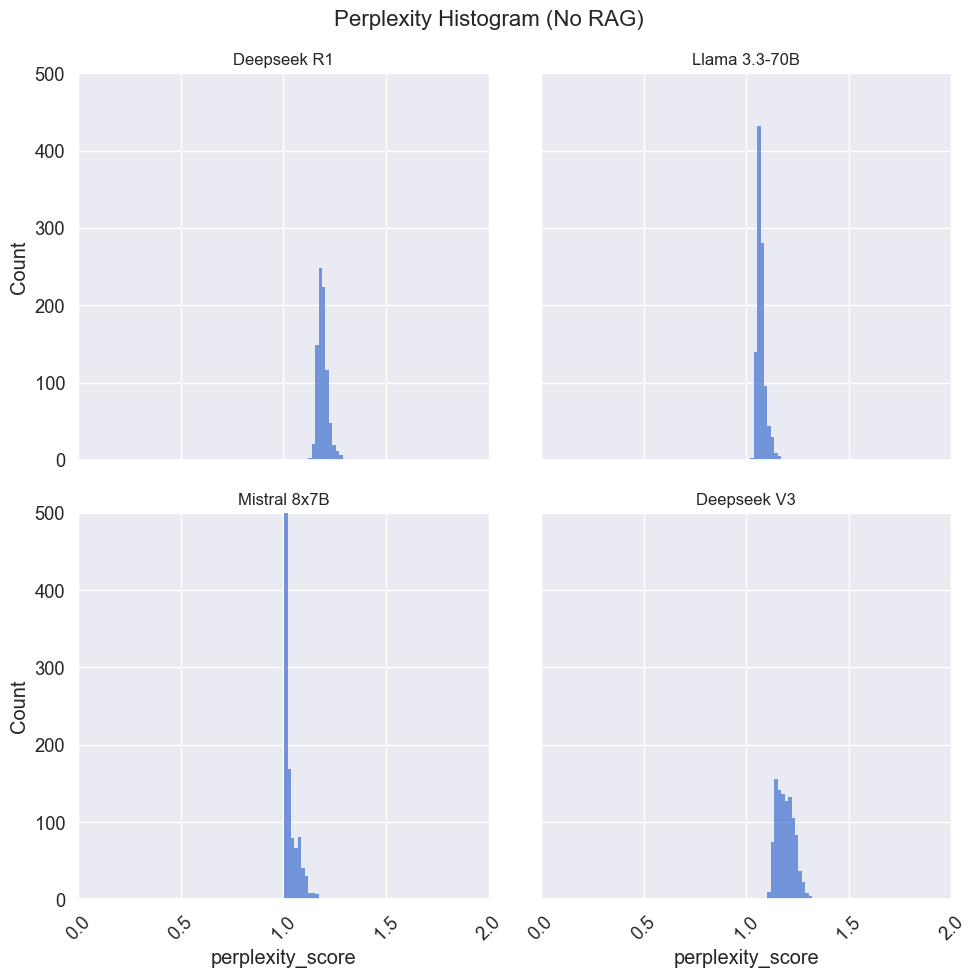

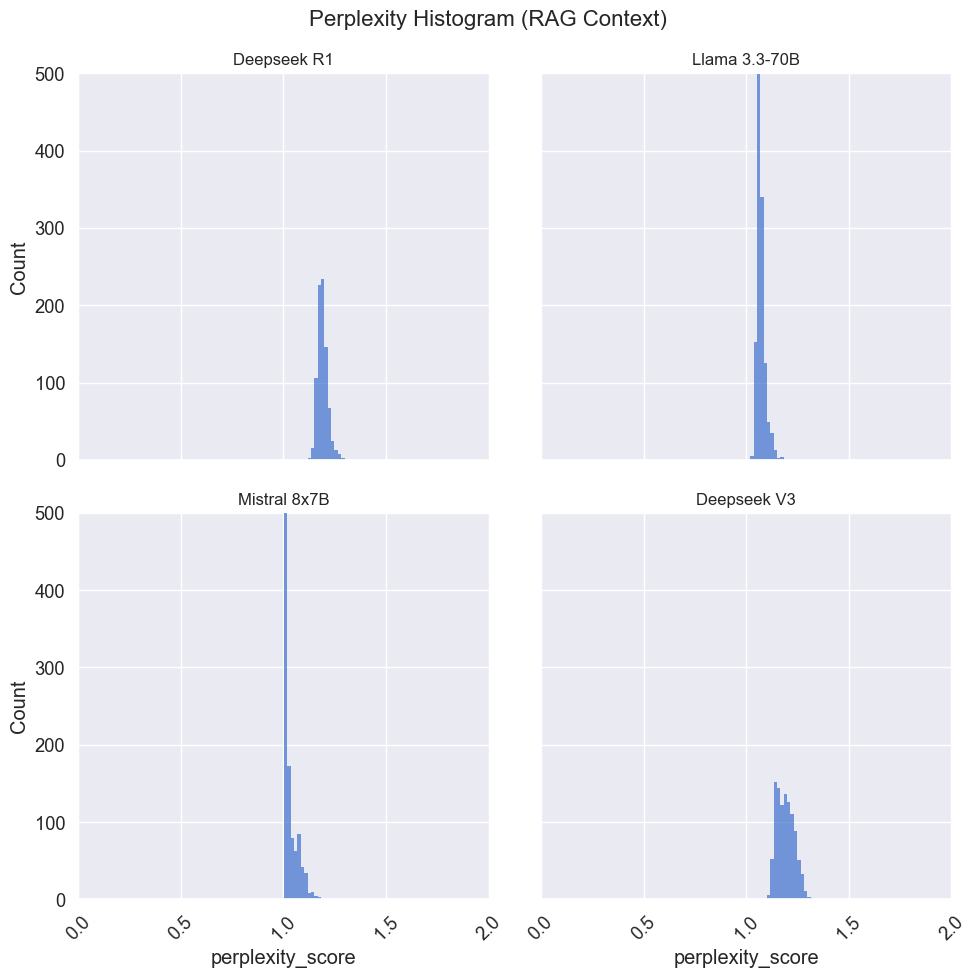

In [22]:
plot_perplexity_histogram_by_model(df2, RAG = False)
plot_perplexity_histogram_by_model(df2, RAG = True)

/var/folders/z6/d0zj0b9s1lv9vyh5km30751h0000gn/T/ipykernel_33383/1110102520.py:444: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['model'] = df['model'].map(model_name_map)
/var/folders/z6/d0zj0b9s1lv9vyh5km30751h0000gn/T/ipykernel_33383/1110102520.py:447: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['topic']= df['category'].apply(classify_paper)


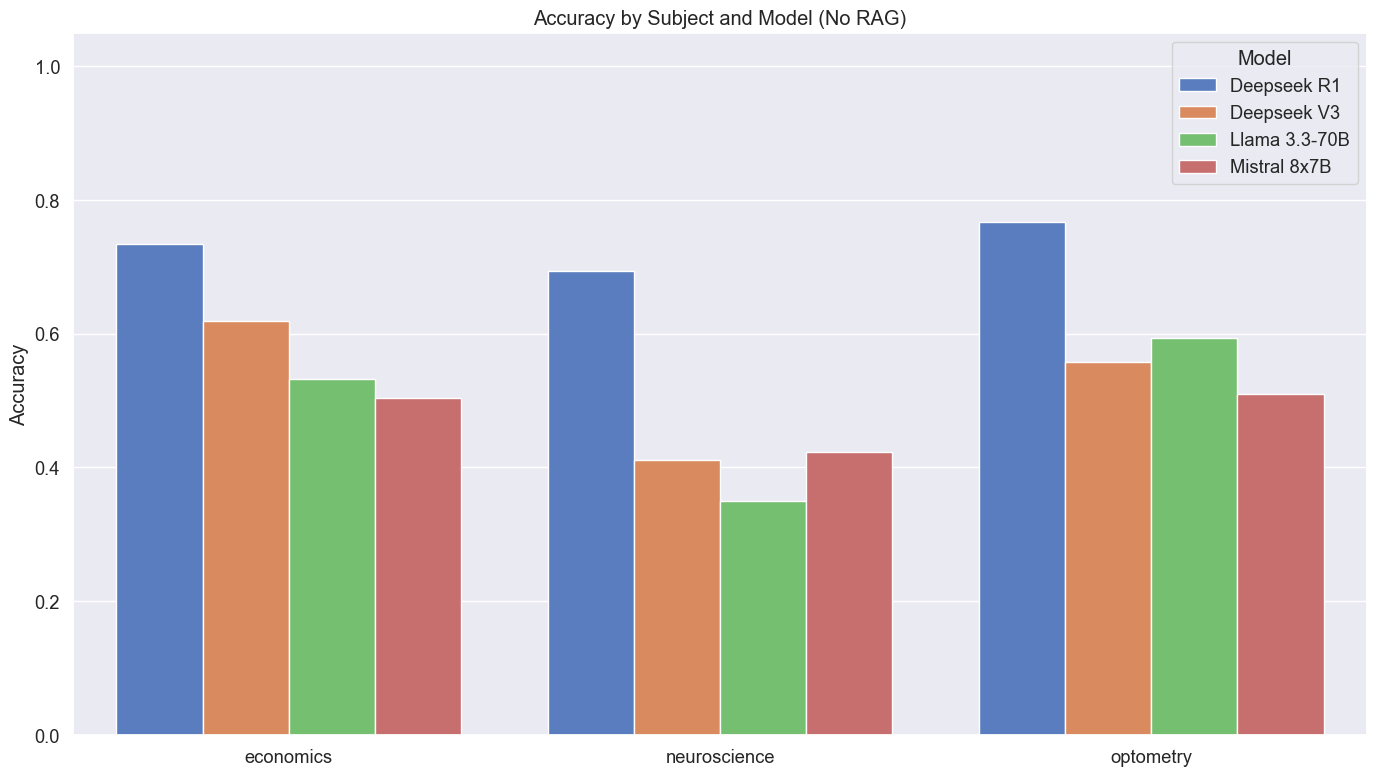

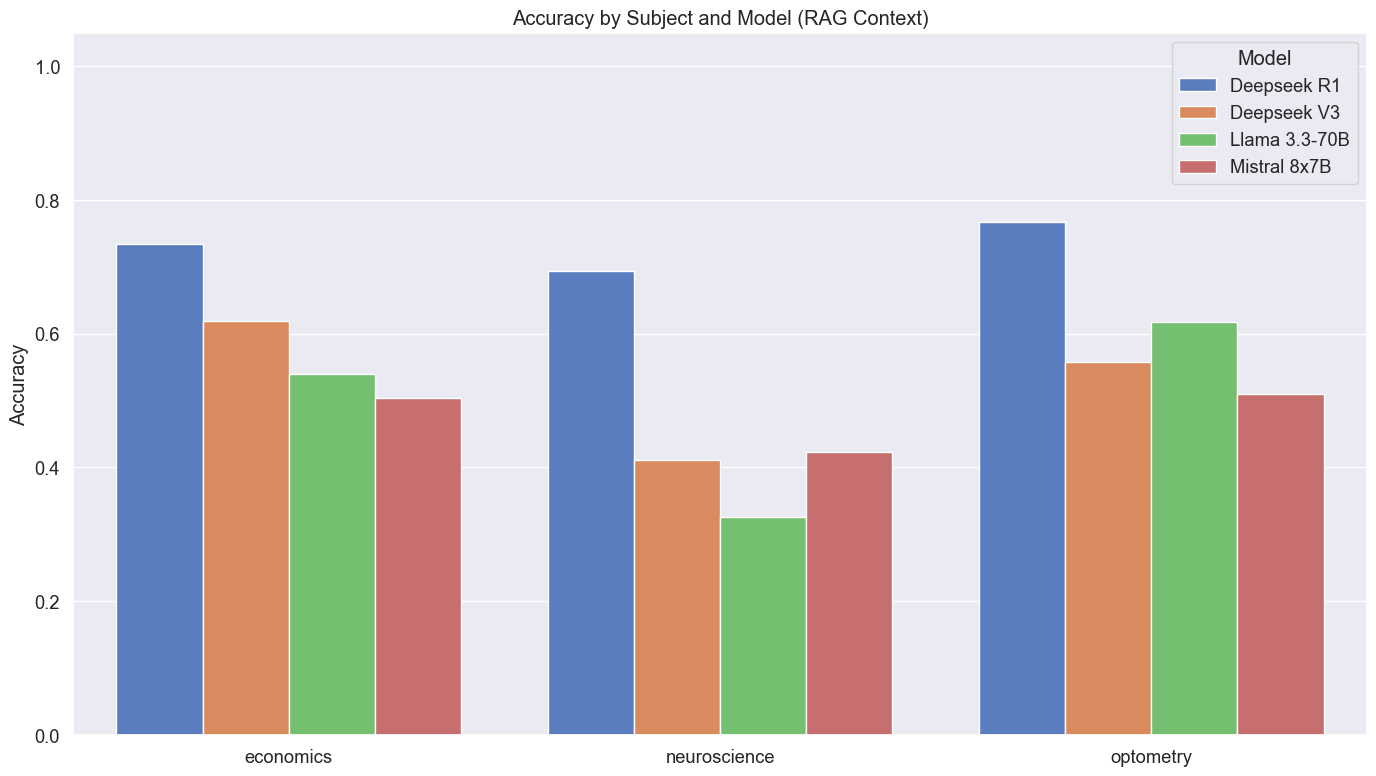

In [23]:
accuracy_by_subject_by_model(df2, RAG = False)
accuracy_by_subject_by_model(df2, RAG = True)

In [24]:
session.close()